## Physique des marchés, TP1 : faits stylisés

#### 2.1 Données journalières

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

[*********************100%***********************]  1 of 1 completed


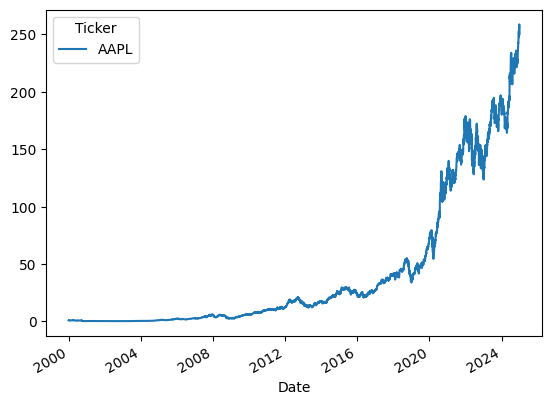

In [10]:
AAPL_daily = yf.download('AAPL', start='2000-01-01', end='2025-01-01')
AAPL_daily['Close'].plot()
plt.show()

In [11]:
AAPL_daily

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600
2000-01-05,0.782433,0.831806,0.774910,0.780553,778321600
2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400
...,...,...,...,...,...
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100


#### 2.2 Données intraday

In [12]:
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
    DF = pd.read_csv(filename)

    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [13]:
Path = sys.path[0]
AAPL_intraday = load_TRTH_bbo(Path+"\\2017-01-03-AAPL.OQ-bbo.csv.gz")
AAPL_intraday

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Program Files\\JetBrains\\PyCharm 2023.3.3\\plugins\\python\\helpers-pro\\jupyter_debug\\2017-01-03-AAPL.OQ-bbo.csv.gz'

#### 3. Calcul des rendements

#### 3.1 Données journalières

In [ ]:
AAPL_daily["Returns"] = np.log(AAPL_daily['Close']).diff().values
AAPL_daily.dropna()
